# Simulating Dickey–Fuller distributions
100 samples, can be adjusted

In [58]:
library(tidyverse)
library(gridExtra) # Arrangning ggplots
library(dynlm)

theme_set(theme_grey())

options(repr.plot.width=8, repr.plot.height=3)

## Simulation with lag, drift and trend

In [3]:
tau1 <- NA
for (i in 1:1000) {
    x <- as.ts(cumsum(rnorm(100)))
    a <- summary(dynlm(x ~ L(x) + seq_along(x)))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau1[i] <- new
}

## Simulation with lag and drift

In [4]:
tau2 <- NA
for (i in 1:1000) {
    x <- as.ts(cumsum(rnorm(100)))
    a <- summary(dynlm(x ~ L(x)))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau2[i] <- new
}

## Simulation with lag

In [5]:
tau3 <- NA
for (i in 1:1000) {
    x <- as.ts(cumsum(rnorm(100)))
    a <- summary(dynlm(x ~ L(x) + 0))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau3[i] <- new
}

In [113]:
zndist <- rnorm(1000)
ndistq <- quantile(zndist, probs = c(0.01,0.025,0.05))
tau1q <- quantile(tau1, probs = c(0.01,0.025,0.05))
tau2q <- quantile(tau2, probs = c(0.01,0.025,0.05))
tau3q <- quantile(tau3, probs = c(0.01,0.025,0.05))
quantiles <- cbind(tau1q,tau2q,tau3q, ndistq)
colnames(quantiles) = c("tau1", "tau2", "tau3", "ndist")
quantiles

,tau1,tau2,tau3,ndist
1%,-3.964999,-3.575323,-2.498326,-2.199623
2.5%,-3.713851,-3.188845,-2.231904,-1.853148
5%,-3.396394,-2.796412,-1.869160,-1.563988


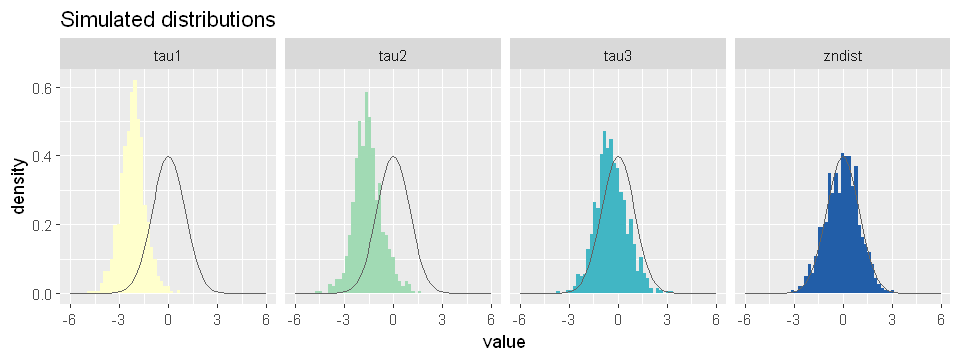

In [105]:
adf <- data.frame(zndist,tau1,tau2,tau3) %>%
  gather(variable, value)

p1 <- ggplot(adf, aes(value, fill=variable)) + 
  geom_histogram(bins=60, aes(y = ..density..)) + 
  scale_fill_brewer(guide=F, palette="YlGnBu") +
  stat_function(fun=dnorm, color="#636363", args=list(mean=0, sd=1)) +
  facet_wrap(~variable, nrow=1) + 
  scale_x_continuous(limits = c(-6, 6)) +
  labs(title="Simulated distributions")
print(p1)

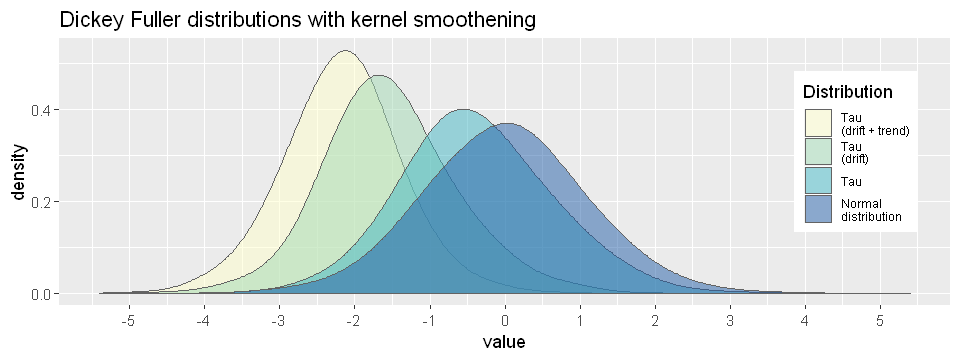

In [78]:
df <- data.frame(tau1, tau2, tau3, zndist) %>%
  gather(variable, value)

p2 <- ggplot(df, aes(value, fill=variable)) + 
  geom_density(adjust=2, alpha=0.5, color="#636363") + 
  scale_fill_brewer(name="Distribution", 
                    labels = c("Tau\n(drift + trend)", 
                               "Tau\n(drift)", 
                               "Tau",
                               "Normal\ndistribution"), 
                    palette="YlGnBu",
                    direction=1) + 
  labs(title="Dickey Fuller distributions with kernel smoothening") + 
  scale_x_continuous(limits = c(-5.4, 5.4), breaks=seq(-5,5,by=1)) +
  theme(legend.text=element_text(size=7),
        legend.justification = c(1, 1), 
        legend.box.margin=margin(c(20,20,50,50)),
        legend.position = c(1, 1))
  print(p2)

## Simulating with matrix formulas (significaltly faster)

In [63]:
T = 100
df <- rep(NA, 10000)

for (i in 1:10000) {
yt <- cumsum(rnorm(T))
X <- cbind(1,yt[-T])
beta <- solve(t(X) %*% X) %*% t(X) %*% yt[-1] 
ssr <- sum((yt[-1] - X %*% beta)^2)
se <- sqrt(ssr / (T-3)) / sqrt(sum((X[,2] - mean(X[,2]))^2))

df[i] <- (beta[2] - 1) / se
}

df %>%
  quantile(probs = c(0.01, 0.025, 0.05)) %>%
  as.data.frame()

,.
1%,-3.487272
2.5%,-3.162407
5%,-2.894157
